## QAOA

In [ ]:
!pip install cirq

     |████████████████████████████████| 1.6MB 6.1MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import scipy.optimize
import cirq
from cirq.contrib.svg import SVGCircuit

In [ ]:
def fswap(p, q):
    """Decompose the Fermionic SWAP gate into two single-qubit gates and
    one iSWAP gate.
    Args:
        p: the id of the first qubit
        q: the id of the second qubit
    """

    yield cirq.ISWAP(q, p), cirq.Z(p) ** 1.5
    yield cirq.Z(q) ** 1.5


def bogoliubov_trans(p, q, theta):
    r"""The 2-mode Bogoliubov transformation is mapped to two-qubit operations.
     We use the identity X S^\dag X S X = Y X S^\dag Y S X = X to transform
     the Hamiltonian XY+YX to XX+YY type. The time evolution of the XX + YY
     Hamiltonian can be expressed as a power of the iSWAP gate.
    Args:
        p: the first qubit
        q: the second qubit
        theta: The rotational angle that specifies the Bogoliubov
        transformation, which is a function of the kinetic energy and
        the superconducting gap.
    """

    # The iSWAP gate corresponds to evolve under the Hamiltonian XX+YY for
    # time -pi/4.
    expo = -4 * theta / np.pi

    yield cirq.X(p)
    yield cirq.S(p)
    yield cirq.ISWAP(p, q)**expo
    yield cirq.S(p) ** 1.5
    yield cirq.X(p)


def fermi_fourier_trans_2(p, q):
    """The 2-mode fermionic Fourier transformation can be implemented
    straightforwardly by the √iSWAP gate. The √iSWAP gate can be readily
    implemented with the gmon qubits using the XX + YY Hamiltonian. The matrix
    representation of the 2-qubit fermionic Fourier transformation is:
    [1  0      0      0],
    [0  1/√2   1/√2   0],
    [0  1/√2  -1/√2   0],
    [0  0      0     -1]
    The square root of the iSWAP gate is:
    [1, 0, 0, 0],
    [0, 0.5 + 0.5j, 0.5 - 0.5j, 0],
    [0, 0.5 - 0.5j, 0.5 + 0.5j, 0],
    [0, 0, 0, 1]
    Args:
        p: the first qubit
        q: the second qubit
    """

    yield cirq.Z(p)**1.5
    yield cirq.ISWAP(q, p)**0.5
    yield cirq.Z(p)**1.5


def fermi_fourier_trans_inverse_4(qubits):
    """The reverse fermionic Fourier transformation implemented on 4 qubits
    on a line, which maps the momentum picture to the position picture.
    Using the fast Fourier transformation algorithm, the circuit can be
    decomposed into 2-mode fermionic Fourier transformation, the fermionic
    SWAP gates, and single-qubit rotations.
    Args:
        qubits: list of four qubits
    """

    yield fswap(qubits[1], qubits[2]),
    yield fermi_fourier_trans_2(qubits[0], qubits[1])
    yield fermi_fourier_trans_2(qubits[2], qubits[3])
    yield fswap(qubits[1], qubits[2])
    yield fermi_fourier_trans_2(qubits[0], qubits[1])
    yield cirq.S(qubits[2])
    yield fermi_fourier_trans_2(qubits[2], qubits[3])
    yield fswap(qubits[1], qubits[2])


def fermi_fourier_trans_inverse_conjugate_4(qubits):
    """We will need to map the momentum states in the reversed order for
    spin-down states to the position picture. This transformation can be
    simply implemented the complex conjugate of the former one. We only
    need to change the S gate to S* = S ** 3.
    Args:
        qubits: list of four qubits
    """

    yield fswap(qubits[1], qubits[2]),
    yield fermi_fourier_trans_2(qubits[0], qubits[1])
    yield fermi_fourier_trans_2(qubits[2], qubits[3])
    yield fswap(qubits[1], qubits[2])
    yield fermi_fourier_trans_2(qubits[0], qubits[1])
    yield cirq.S(qubits[2]) ** 3
    yield fermi_fourier_trans_2(qubits[2], qubits[3])
    yield fswap(qubits[1], qubits[2])

def bcs_parameters(n_site, n_fermi, u, t) :
    """Generate the parameters for the BCS ground state, i.e., the
    superconducting gap and the rotational angles in the Bogoliubov
    transformation.
     Args:
        n_site: the number of sites in the Hubbard model
        n_fermi: the number of fermions
        u: the interaction strength
        t: the tunneling strength
    Returns:
        float delta, List[float] bog_theta
    """

    # The wave numbers satisfy the periodic boundary condition.
    wave_num = np.linspace(0, 1, n_site, endpoint=False)
    # The hopping energy as a function of wave numbers
    hop_erg = -2 * t * np.cos(2 * np.pi * wave_num)
    # Finding the Fermi energy
    fermi_erg = hop_erg[n_fermi // 2]
    # Set the Fermi energy to zero
    hop_erg = hop_erg - fermi_erg

    def _bcs_gap(x):
        """Defines the self-consistent equation for the BCS state vector.
        Args:
            x: the superconducting gap
        """

        s = 0.
        for i in range(n_site):
            s += 1. / np.sqrt(hop_erg[i] ** 2 + x ** 2)
        return 1 + s * u / (2 * n_site)

    # Superconducting gap
    delta = scipy.optimize.bisect(_bcs_gap, 0.01, 10000. * abs(u))
    # The amplitude of the double excitation state
    bcs_v = np.sqrt(0.5 * (1 - hop_erg / np.sqrt(hop_erg ** 2 + delta ** 2)))
    # The rotational angle in the Bogoliubov transformation.
    bog_theta = np.arcsin(bcs_v)

    return delta, bog_theta


In [ ]:
# Number of sites in the Fermi-Hubbard model (2*n_site spin orbitals)
n_site = 4
# Number of fermions
n_fermi = 4
# Hopping strength between neighboring sites
t = 1.
# On-site interaction strength. It has to be negative (attractive) for the
# BCS theory to work.
u = -4.
# Calculate the superconducting gap and the angles for BCS
delta, bog_theta = bcs_parameters(n_site, n_fermi, u, t)
# Initializing the qubits on a ladder

print('Quantum circuits to prepare the BCS meanfield state.')
print('Number of sites = ', n_site)
print('Number of fermions = ', n_fermi)
print('Tunneling strength = ', t)
print('On-site interaction strength = ', u)
print('Superconducting gap = ', delta, '\n')

upper_qubits = [cirq.GridQubit(0, i) for i in range(n_fermi)]
lower_qubits = [cirq.GridQubit(1, i) for i in range(n_fermi)]

bog_circuit = cirq.Circuit(
    bogoliubov_trans(upper_qubits[i], lower_qubits[i], bog_theta[i])
    for i in range(n_site))

# The inverse fermionic Fourier transformation on the spin-up states
fourier_circuit_spin_up = cirq.Circuit(
    fermi_fourier_trans_inverse_4(upper_qubits),
    strategy=cirq.InsertStrategy.EARLIEST)

# The inverse fermionic Fourier transformation on the spin-down states
fourier_circuit_spin_down = cirq.Circuit(
    fermi_fourier_trans_inverse_conjugate_4(lower_qubits),
    strategy=cirq.InsertStrategy.EARLIEST)

Quantum circuits to prepare the BCS meanfield state.
Number of sites =  4
Number of fermions =  4
Tunneling strength =  1.0
On-site interaction strength =  -4.0
Superconducting gap =  1.1261371093950703 



In [ ]:
def State_Prep():
  '''The BCS ground state is prepared in the site basis by first preparing the
  ground state in the momentum basis and then applying the 2D Fourier
  transformation to the two spin states independently. The ground state in the
  momentum basis can be prepared by applying a Bogoliubov transformation to the 
  vacuum state. 
  '''
  circuit = cirq.Circuit()

  bog_circuit = cirq.Circuit(
    bogoliubov_trans(upper_qubits[i], lower_qubits[i], bog_theta[i])
    for i in range(n_site))

  # The inverse fermionic Fourier transformation on the spin-up states
  fourier_circuit_spin_up = cirq.Circuit(
      fermi_fourier_trans_inverse_4(upper_qubits),
      strategy=cirq.InsertStrategy.EARLIEST)

  # The inverse fermionic Fourier transformation on the spin-down states
  fourier_circuit_spin_down = cirq.Circuit(
      fermi_fourier_trans_inverse_conjugate_4(lower_qubits),
      strategy=cirq.InsertStrategy.EARLIEST)

  circuit.append(bog_circuit)
  circuit.append(fourier_circuit_spin_up)
  circuit.append(fourier_circuit_spin_down)

  return circuit

def H_FH(dt):
  #Fermi-Hubbard Hamiltonian time evolution
  circuit = cirq.Circuit()
  circuit.append(hopping())
  circuit.append(interaction())
  circuit.append(chem_pot())
  circuit.append(zeeman())
  return circuit

def H_DW(dt):
  #d-wave Hamiltonian time evolution
  circuit = cirq.Circuit()
  circuit.append(hopping())
  circuit.append(chem_pot())
  circuit.append(pairing())
  return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


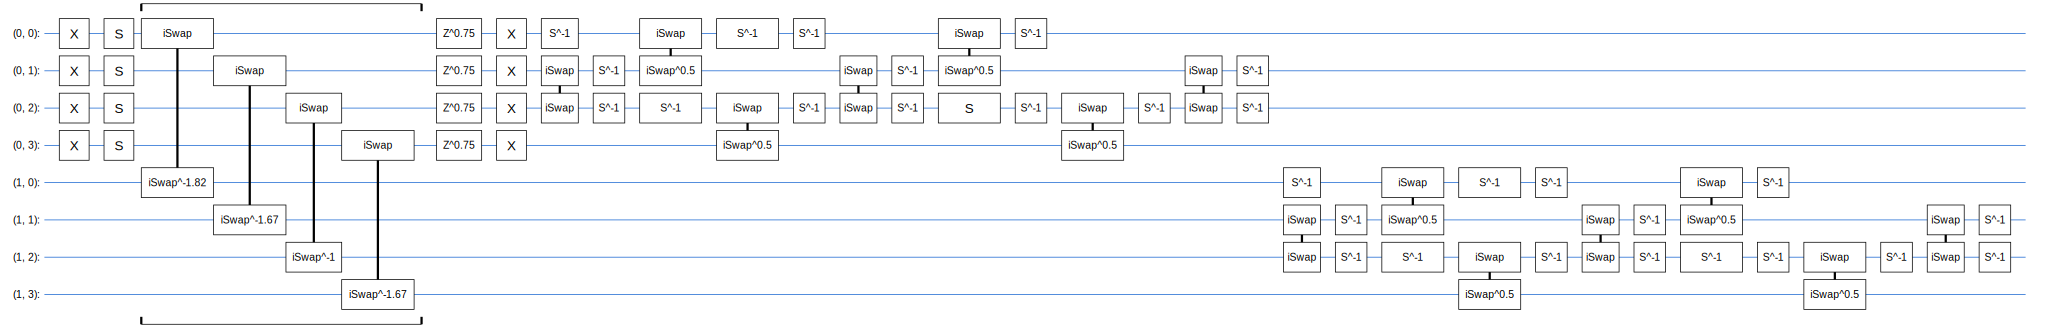

In [ ]:
SVGCircuit(State_Prep())

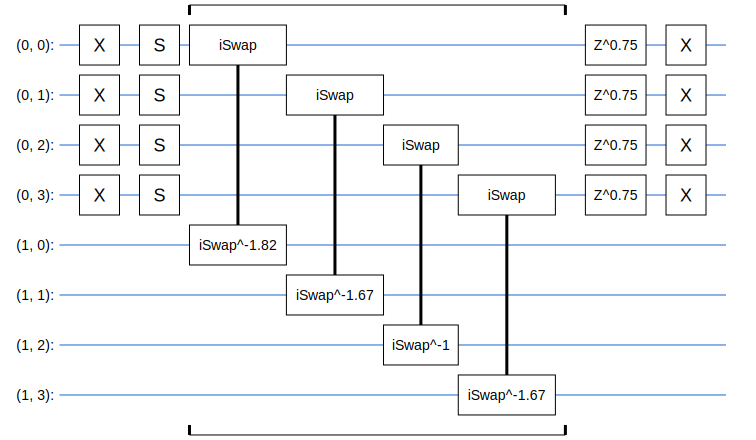

In [ ]:
SVGCircuit(bog_circuit)

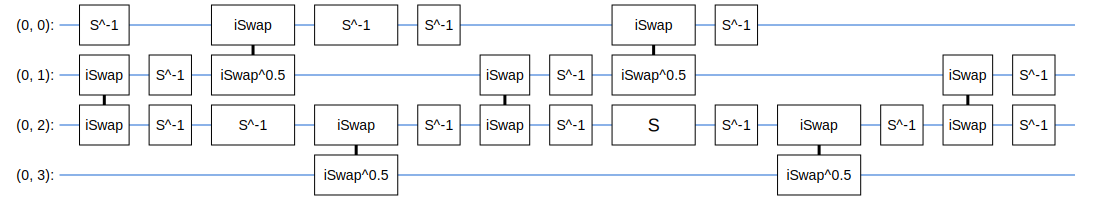

In [ ]:
SVGCircuit(fourier_circuit_spin_up)

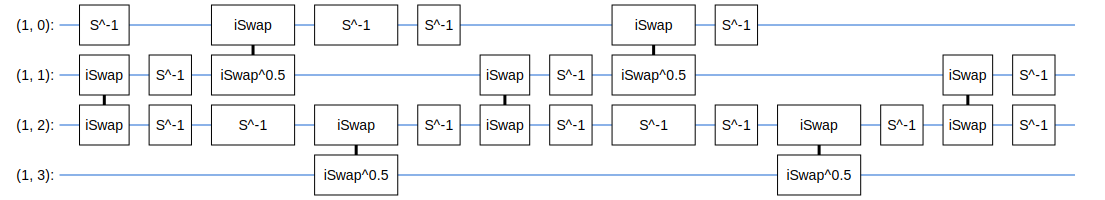

In [ ]:
SVGCircuit(fourier_circuit_spin_down)